In [1]:
import tensorflow as tf
from tensorflow import keras

from google.colab import drive

drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [3]:
import numpy as np
import pandas as pd
import re
#from sentiment_utils import *
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from nltk.corpus import stopwords
np.random.seed(1)
from sklearn.model_selection import train_test_split

#from emo_utils import *
import matplotlib.pyplot as plt
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.engine.topology import Layer

Using TensorFlow backend.


In [0]:
class Attention(Layer):
     # Input shape 3D tensor with shape: `(samples, steps, features)`.
     # Output shape 2D tensor with shape: `(samples, features)`.

    def __init__(self, step_dim,W_regulizer = None,b_regulizer = None,
                 W_constraint = None, b_constraint = None,bias = True,**kwargs):
        
        self.W_regulizer = W_regulizer
        self.b_regulizer = b_regulizer
        
        self.W_constraint = W_constraint
        self.b_constraint = b_constraint
        
        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        self.init = initializers.get('glorot_uniform')
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        # Create a trainable weight variable for this layer.
        self.W = self.add_weight(name='kernel', 
                                      shape=(input_shape[-1],),
                                      initializer= self.init,
                                      constraint = self.W_constraint,
                                      regularizer = self.W_regulizer)
#                                       name = '{}_W'.format(self.name)
        
        self.features_dim = input_shape[-1]
        
        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regulizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
        super(Attention, self).build(input_shape)  

    
    def call(self, x, mask=None):
      
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
           
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
    
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim


In [0]:
def remove_stopwords(input_text):
    '''
    Function to remove English stopwords from a Pandas Series.
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words)

def remove_mentions(input_text):
    '''
    Function to remove mentions, preceded by @, in a Pandas Series
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    return re.sub(r'@\w+', '', input_text)

In [6]:
#Read the data
train_df = pd.read_csv('/content/gdrive/My Drive/Tweets_v2.csv',encoding="latin-1")
train_df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [0]:
#check Different labels for Sentiment
Mood = train_df['airline_sentiment'].value_counts()

In [8]:
#cleaning Data
train_df = train_df[['text', 'airline_sentiment']]
train_df.text = train_df.text.apply(remove_mentions)
train_df.loc[:,'sentiment'] = train_df.airline_sentiment.map({'negative':0,'neutral':1,'positive':2})
train_df = train_df.drop(['airline_sentiment'], axis=1)
train_df.head()

,text,sentiment
0,What said.,1
1,plus you've added commercials to the experien...,2
2,I didn't today... Must mean I need to take an...,1
3,"it's really aggressive to blast obnoxious ""en...",0
4,and it's a really big bad thing about it,0


In [0]:
#This step is to find the maximun length of the input string so as to fed the neural net with same length
raw_docs_train = train_df["text"].values
sentiment_train = train_df['sentiment'].values

maxLen = len(max(raw_docs_train, key=len).split())

In [10]:
#For our model we need to split our training dataset into test dataset. This is actually dev set for getting the loss
X_train, X_test, Y_train, Y_test = train_test_split(raw_docs_train, sentiment_train, 
                                                  stratify=sentiment_train, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, 
                                                  stratify=Y_train, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)


print('# Train data samples:', X_train.shape)
print('# Test data samples:', X_test.shape)
assert X_train.shape[0] == Y_train.shape[0]
assert X_val.shape[0] == Y_val.shape[0]
assert X_test.shape[0] == Y_test.shape[0]

# Train data samples: (11858,)
# Test data samples: (1464,)


In [11]:
#Convert the labels to One hot encoding vector for softmax for neural network

#Y_oh_train = convert_to_one_hot(Y_train, C = num_labels)
num_labels = len(np.unique(sentiment_train))
Y_oh_train = np_utils.to_categorical(Y_train, num_labels)
Y_oh_val = np_utils.to_categorical(Y_val, num_labels)
Y_oh_test = np_utils.to_categorical(Y_test, num_labels)
print(Y_oh_train.shape)

(11858, 3)


In [0]:
#Now we need Glove Vectors for Word which is available online 
#word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('Data/glove.6B.50d.txt')

# load the GloVe vectors in a dictionary:

def read_glove_vecs(glove_file):
    with open(glove_file, encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map



word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('/content/gdrive/My Drive/glove.6B.50d.txt')

In [13]:
word = "cucumber"
index = 289846
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(index) + "th word in the vocabulary is", index_to_word[index])

the index of cucumber in the vocabulary is 113317
the 289846th word in the vocabulary is potatos


In [0]:
# This function convert array of strings into array of Indices of word in the voacab.

def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m,max_len))
    
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words =[word.lower().replace('\t', '') for word in X[i].split(' ') if word.replace('\t', '') != '']
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            try:
                X_indices[i, j] = word_to_index[w]
            except: 0
            # Increment j to j + 1
            j = j+1
    
    return X_indices

In [0]:
# Create Keras Embedding layer
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    ### START CODE HERE ###
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len,emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim, trainable = False)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [16]:
from keras import initializers, regularizers, constraints
from keras import backend as K
from keras.layers import LSTM, Bidirectional, Dropout

act = 'relu'
### START CODE HERE ###
sentence_indices =  Input(shape=(maxLen,), dtype='int32')
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
embeddings = embedding_layer(sentence_indices)  
X = Bidirectional(LSTM(256, return_sequences=True, dropout=0.5,recurrent_dropout=0.25))(embeddings)
X = Attention(maxLen)(X)
X = Dense(128, activation = act)(X)
X = BatchNormalization()(X)
X = Dropout(0.5)(X)
X = Dense(64, activation = act)(X)
X = BatchNormalization()(X)
X = Dropout(0.5)(X)
X = Dense(3, activation=None)(X)
X = Activation('softmax')(X)
   
model = Model(inputs=[sentence_indices], outputs=X)
    

    


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [18]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
X_val_indices = sentences_to_indices(X_val, word_to_index, maxLen)
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
print(X_train_indices.shape)

(11858, 26)


Instructions for updating:
Use tf.cast instead.
Train on 11858 samples, validate on 1318 samples
Epoch 1/300
11858/11858 [==============================] - 7s 570us/step - loss: 1.5330 - acc: 0.3915 - val_loss: 1.1236 - val_acc: 0.5015
Epoch 2/300
11858/11858 [==============================] - 4s 332us/step - loss: 1.2713 - acc: 0.4492 - val_loss: 0.8571 - val_acc: 0.6555
Epoch 3/300
11858/11858 [==============================] - 4s 332us/step - loss: 1.1237 - acc: 0.5006 - val_loss: 0.8217 - val_acc: 0.6768
Epoch 4/300
11858/11858 [==============================] - 4s 335us/step - loss: 1.0569 - acc: 0.5421 - val_loss: 0.7786 - val_acc: 0.6874
Epoch 5/300
11858/11858 [==============================] - 4s 332us/step - loss: 0.9919 - acc: 0.5775 - val_loss: 0.7850 - val_acc: 0.6753
Epoch 6/300
11858/11858 [==============================] - 4s 331us/step - loss: 0.9453 - acc: 0.6004 - val_loss: 0.7537 - val_acc: 0.7011
Epoch 7/300
11858/11858 [==============================] - 4s 331us/s

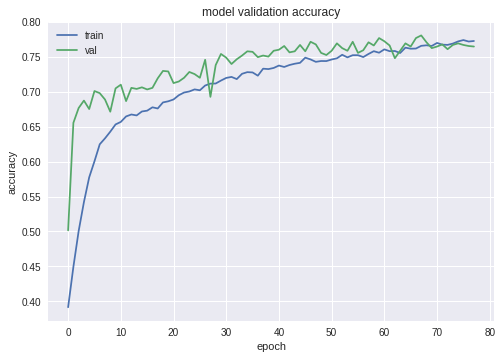

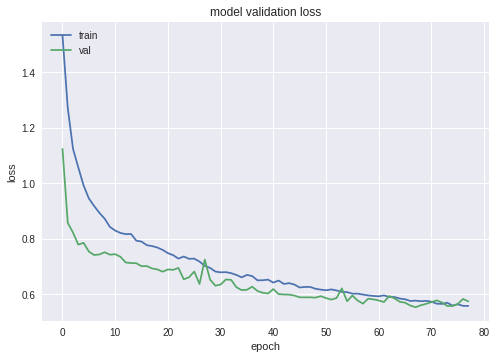

In [19]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

history=model.fit(X_train_indices, y=Y_oh_train, batch_size=512, epochs=300, 
          verbose=1, validation_data=(X_val_indices, Y_oh_val), callbacks=[earlystop])

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [20]:
y_test_predicted = model.predict(X_test_indices)

y_test_predicted_result=[]
for i in range(y_test_predicted.shape[0]):
  y_test_predicted_result=np.append(y_test_predicted_result, y_test_predicted[i].argmax())

print(y_test_predicted_result)
sentiment_test_result=[]
for i in range(Y_test.shape[0]):
  sentiment_test_result=np.append(sentiment_test_result, Y_test[i])


print(sentiment_test_result)

[0. 1. 0. ... 1. 0. 0.]
[0. 0. 0. ... 2. 0. 0.]


In [21]:
from sklearn.metrics import confusion_matrix

confusion_matrix(sentiment_test_result,y_test_predicted_result)

array([[755, 125,  38],
       [ 69, 209,  32],
       [ 42,  42, 152]])

In [22]:
a=1130/1464
print(a)

0.7718579234972678


In [24]:
# the testing function for professor to test the result
# please type the sentences or words in the np.array() in order to predict the sentiment

print("please enter the sequence or words\n")
i=input("please type here \n")     
plt.ion()

xx_test = np.array([i])
X_test_indices = sentences_to_indices(xx_test, word_to_index, maxLen)
print(xx_test[0] +' '+  str(np.argmax(model.predict(X_test_indices))))

# the explination of result here
# negative -> 0
# neutral -> 1
# positive -> 2

please enter the sequence or words

please type here 
good boy
good boy 2
